# Standardized Uptake Value Ratio

To illustrate standardized uptake value ratio (SUVR) calculation,
we will download an <sup>18</sup>F-AV45 amyloid
PET scan from The Dallas Lifespan Brain Study via OpenNeuro.
This PET scan is reconstructed as a single time frame, so it is a 3-D image.
(We can still use _Dynamic PET_ to read it, but most of the functions
implemented in _Dynamic PET_ will not be relevant.)

In [1]:
from pathlib import Path

import requests


outdir = Path.cwd() / "nb_data"
outdir.mkdir(exist_ok=True)

petjson_fname = outdir / "pet_av45.json"
pet_fname = outdir / "pet_av45.nii.gz"

baseurl = "https://s3.amazonaws.com/openneuro.org/ds004856/sub-1003/ses-wave1/pet/"

peturl = (
    baseurl
    + "sub-1003_ses-wave1_trc-18FAV45_run-1_pet.nii.gz"
    + "?versionId=qL.9p.hInakWrNSF1LeefT4VOIuBy6Xm"
)

if not petjson_fname.exists():
    r = requests.get(
        baseurl
        + "sub-1003_ses-wave1_trc-18FAV45_run-1_pet.json"
        + "?versionId=HvaYMcTWZjYwq6GVwjfeePZ9dKAtJlFM",
        timeout=10,
    )
    r.raise_for_status()
    with open(petjson_fname, "wb") as f:
        f.write(r.content)

if not pet_fname.exists():
    with requests.get(peturl, timeout=10, stream=True) as r:
        r.raise_for_status()
        with open(pet_fname, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

At the time of writing of this notebook, this dataset is not PET-BIDS valid.
Trying to read it with the `load` function from
`dynamicpet.petbids.petbidsimage` will fail.
Because of this, we need to fix the json first.

We can first read the json using the `read_json` from the same module.
`read_json` does not perform any validity checks (and does not look at the
corresponding imaging data at all).

In [2]:
from dynamicpet.petbids.petbidsjson import read_json


json = read_json(petjson_fname)

The problem with this dataset is that the image contains only a single time
frame, but the json indicates two time frames, with the second one having a
duration of 0.

In [3]:
print(f"FrameDuration: {json["FrameDuration"]}")
print(f"FrameTimesStart: {json["FrameTimesStart"]}")

FrameDuration: [600000]
FrameTimesStart: [0]


We modify these tags by keeping their first element only.

In [4]:
json.update(
    {
        "FrameDuration": json["FrameDuration"][:1],
        "FrameTimesStart": json["FrameTimesStart"][:1],
    }
)

print(f"FrameDuration: {json["FrameDuration"]}")
print(f"FrameTimesStart: {json["FrameTimesStart"]}")

FrameDuration: [600000]
FrameTimesStart: [0]


Now that the frame timing information is fixed, we update the json file using
the `write_json` function:

In [5]:
from dynamicpet.petbids.petbidsjson import write_json


write_json(json, petjson_fname)

Now, reading in this dataset will work:

In [6]:
from dynamicpet.petbids.petbidsimage import load


pet = load(pet_fname)

To calculate SUVR, we need to specify a reference region.
Usually, some type of cerebellar reference would be used for
<sup>18</sup>F-AV45.
In this notebook, however, we use an (approximate) whole brain reference region
for simplicity.

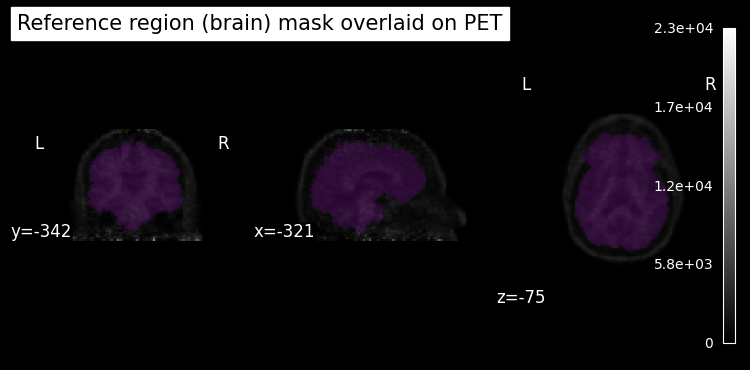

In [7]:
from nilearn.image import threshold_img
from nilearn.masking import compute_background_mask
from nilearn.plotting import plot_anat
from scipy.ndimage import binary_fill_holes


# get an approximate brain mask
refmask = compute_background_mask(
    threshold_img(pet.img, threshold=1400, two_sided=False),
    connected=True,
    opening=3,
)
refmask_data = binary_fill_holes(refmask.get_fdata())

refmask = refmask.__class__(refmask_data.astype("float"), affine=refmask.affine)
display = plot_anat(
    pet_fname,
    colorbar=True,
    draw_cross=False,
    title="Reference region (brain) mask overlaid on PET",
)
display.add_overlay(refmask, alpha=0.5)

Next, we calculate the mean time activity "curve" (TAC) in this reference region
mask.

In [8]:
reftac = pet.mean_timeseries_in_mask(mask=refmask.get_fdata())

reftac.dataobj

array([[2910.44148055]])

Since this PET image has a single time frame, the "TAC" will also have a
single element.

In [9]:
reftac.dataobj

array([[2910.44148055]])

We can fit the SUVR model as follows:

In [10]:
from dynamicpet.kineticmodel.suvr import SUVR


res = SUVR(reftac, pet)
res.fit()

We can see the names of the parameters using the `get_param_names` function.
The only parameter available in the `SUVR` class is `suvr`:

In [11]:
res.get_param_names()

['suvr']

The best way to access the calculated parameter is via the `get_parameter`
function, which will appropriately reshape the calculated parameter if needed
and make it into a `SpatialImage`.
We can then use `nilearn` functions to plot the image.

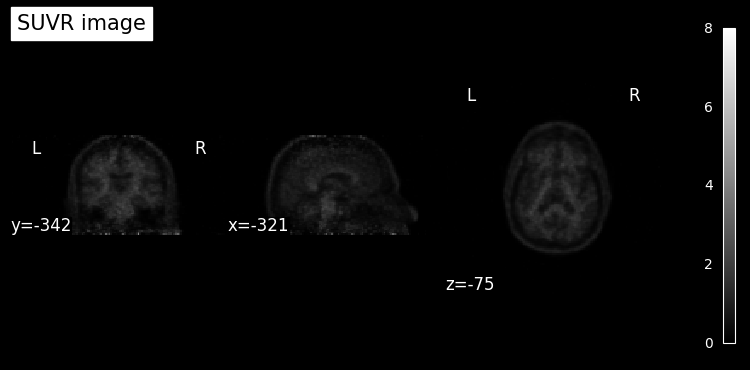

In [12]:
plot_anat(
    res.get_parameter("SUVR"),
    colorbar=True,
    draw_cross=False,
    title="SUVR image",
);

## Command line interface

Instead of using the Python API, we can also perform SUVR calculation via the
command line.

First, we need to have the reference region mask to disk.

In [13]:
refmask.to_filename("nb_data/refmask.nii.gz")

Then, we can run the command from terminal:

In [14]:
!kineticmodel nb_data/pet_av45.nii.gz --model SUVR --refmask nb_data/refmask.nii.gz --outputdir nb_data

The SUVR image will be saved to a file suffixed with `_km-suvr_kp-suvr`,
where `km` stands for kinetic model and `kp` stands for kinetic parameter.
This file naming convention is based on the PET-BIDS Derivatives Extension
(work in progress).